In [1]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [58]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

For each echo, mark whether or not there is an outpatient echo before/after. 

In [4]:
query = \
"""
WITH pairs AS (
    SELECT ed.row_id AS op_rowid, ei.row_id AS icu_rowid
        ,ed.charttime AS op_charttime
        ,ei.charttime AS icu_charttime
        ,ei.subject_id
        ,ei.icustay_id
        ,CASE WHEN ed.charttime > ei.charttime THEN 1 ELSE 0 END AS op_after
        ,CASE WHEN ed.charttime < ei.charttime THEN 1 ELSE 0 END AS op_before
        ,ed.charttime - ei.charttime AS op_to_icu
        ,ei.charttime - ed.charttime AS icu_to_op
        ,CASE WHEN ed.technicalquality = 'Good' THEN 3
              WHEN ed.technicalquality = 'Adequate' THEN 2
              WHEN ed.technicalquality = 'Suboptimal' THEN 1
         ELSE 0 END AS tq
    FROM echodata ed
    INNER JOIN echo_icustay ei
    ON ei.subject_id = ed.subject_id
    WHERE ed.status = 'Outpatient' 
)
-- find 
, proximal_after AS (
    SELECT ps.icu_rowid, MIN(ps.op_to_icu) AS op_to_icu
    FROM pairs ps
    WHERE ps.op_after = 1
    GROUP BY ps.icu_rowid
)
, proximal_before AS (
    SELECT ps.icu_rowid, MIN(ps.icu_to_op) AS icu_to_op
    FROM pairs ps
    WHERE ps.op_before = 1
    GROUP BY ps.icu_rowid
)
, proximal_after_ AS (
    SELECT ps.* FROM proximal_after pa
    INNER JOIN pairs ps
        ON pa.icu_rowid = ps.icu_rowid
        AND pa.op_to_icu = ps.op_to_icu
)
, proximal_before_ AS (
    SELECT ps.* FROM proximal_before pb
    INNER JOIN pairs ps
        ON pb.icu_rowid = ps.icu_rowid
        AND pb.icu_to_op = ps.icu_to_op
)
, proximal_quality_after AS (
    SELECT pa.icu_rowid, MAX(tq) AS tq FROM proximal_after_ pa
    GROUP BY pa.icu_rowid
)
, proximal_quality_before AS (
    SELECT pb.icu_rowid, MAX(tq) AS tq FROM proximal_before_ pb
    GROUP BY pb.icu_rowid
)
, proximal_quality_after_ AS (
    SELECT pa.* FROM proximal_quality_after pqa
    INNER JOIN proximal_after_ pa
        ON pqa.icu_rowid = pa.icu_rowid
        AND pqa.tq = pa.tq
)
, proximal_quality_before_ AS (
    SELECT pb.* FROM proximal_quality_before pqb
    INNER JOIN proximal_before_ pb
        ON pqb.icu_rowid = pb.icu_rowid
        AND pqb.tq = pb.tq
)
SELECT 
    CASE WHEN pqa.icu_rowid IS NOT NULL THEN pqa.icu_rowid ELSE pqb.icu_rowid END AS icu_rowid
    ,pqa.op_rowid AS after_rowid
    ,pqb.op_rowid AS before_rowid
    ,pqa.op_to_icu AS op_to_icu
    ,pqb.icu_to_op AS icu_to_op
FROM proximal_quality_after_ pqa
FULL OUTER JOIN proximal_quality_before_ pqb
    ON pqa.icu_rowid = pqb.icu_rowid
"""
op = pd.read_sql_query(query, con)
op.shape

(4896, 5)

Recall that we want to keep the most proximal only. To be more specific, for each inpatient echo, join on patient id and ask if the outpatient echo happened before or after. 

In [5]:
op['icu_rowid'].value_counts().sort_values(ascending = False).head()

98837     1
88075     1
65596     1
100381    1
65536     1
Name: icu_rowid, dtype: int64

In [6]:
op.loc[(op['icu_rowid'] == 67506)]

,icu_rowid,after_rowid,before_rowid,op_to_icu,icu_to_op
1620,67506,67471.0,NaN,27 days 23:50:00,NaT


In [7]:
query = \
"""
SELECT * FROM echodata ed
WHERE ed.row_id in ('67471', '67470');
"""
check = pd.read_sql_query(query, con)
check.head()

,row_id,subject_id,hadm_id,chartdate,charttime,indication,height,weight,bsa,bp,bpsys,bpdias,hr,status,test,doppler,contrast,technicalquality
0,67471,9906,None,2101-12-26,2101-12-26 14:41:00,H/O cardiac surgery.,69.0,190.0,2.02,124/74,124.0,74.0,58.0,Outpatient,TTE (Complete),Full doppler and color doppler,None,Adequate
1,67470,9906,None,2101-12-26,2101-12-26 14:41:00,H/O cardiac surgery.,69.0,190.0,2.02,124/74,124.0,74.0,58.0,Outpatient,TTE (Complete),Full doppler and color doppler,None,Suboptimal


This one is because the data quality of 1 was bad. Unclear what the reason for the other one actually is. 

In [8]:
query = \
"""
SELECT technicalquality, COUNT(row_id) FROM echodata ed
GROUP BY technicalquality;
"""
check = pd.read_sql_query(query, con)
check.head()

,technicalquality,count
0,None,1
1,Suboptimal,9092
2,Adequate,36561
3,Good,140


Check that icu_rowid is unique. 

In [9]:
op['icu_rowid'].value_counts().value_counts()

1    4896
Name: icu_rowid, dtype: int64

In [10]:
op['icu_rowid'].value_counts().value_counts()

1    4896
Name: icu_rowid, dtype: int64

Check: 

In [11]:
op.head()

,icu_rowid,after_rowid,before_rowid,op_to_icu,icu_to_op
0,93689,93688.0,NaN,176 days 23:27:00,NaT
1,85549,85523.0,NaN,31 days 05:18:00,NaT
2,96352,96351.0,NaN,25 days 20:40:00,NaT
3,103673,103672.0,NaN,70 days 21:01:00,NaT
4,63126,63047.0,NaN,5 days 20:53:00,NaT


In [12]:
op.shape

(4896, 5)

In [13]:
op.dropna().shape

(652, 5)

We have 482 inpatient echos that can be associated with outpatient echos before AND after. 

In [17]:
query = \
"""
SELECT *
FROM echo_filtered
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,charttime,icustay_id,hadm_id,subject_id,intime,outtime,intime_to_echo,echo_to_outtime,ps_vaso,diag_xc,age_at_intime,op_to_icu,icu_to_op,time_filter,age_filter
0,62570,2102-04-14 10:00:00,207317,191210,44605,2102-04-14 08:58:39,2102-04-15 17:17:53,01:01:21,1 days 07:17:53,True,False,23809 days 08:58:39,NaT,NaT,True,True
1,68949,2162-06-11 08:53:00,230215,153438,3778,2162-06-11 10:38:17,2162-06-13 18:31:49,-1 days +22:14:43,2 days 09:38:49,True,False,25791 days 10:38:17,NaT,NaT,True,True
2,84167,2191-03-15 00:22:00,279743,180621,19896,2191-03-14 22:55:19,2191-04-05 13:05:09,01:26:41,21 days 12:43:09,True,False,31859 days 22:55:19,NaT,NaT,True,True
3,64922,2181-07-02 11:11:00,290910,170691,59945,2181-07-02 10:41:19,2181-07-03 23:01:06,00:29:41,1 days 11:50:06,True,False,24202 days 10:41:19,NaT,NaT,True,True
4,80126,2173-02-09 09:13:00,221265,112693,26548,2173-02-09 10:42:28,2173-02-10 14:25:27,-1 days +22:30:32,1 days 05:12:27,True,False,21091 days 10:42:28,NaT,NaT,True,True


In [18]:
len(set(op['icu_rowid'].unique()) & set(ef['row_id'].unique()))

342

In [19]:
len(set(op.dropna()['icu_rowid'].unique()) & set(ef['row_id'].unique()))

38

Load: 

In [20]:
query = \
"""
SELECT *
FROM echo_outpatient
"""
ep = pd.read_sql_query(query, con)
ep.head()

,icu_rowid,after_rowid,before_rowid,op_to_icu,icu_to_op
0,93689,93688.0,NaN,176 days 23:27:00,NaT
1,85549,85523.0,NaN,31 days 05:18:00,NaT
2,96352,96351.0,NaN,25 days 20:40:00,NaT
3,103673,103672.0,NaN,70 days 21:01:00,NaT
4,82145,82143.0,82147.0,101 days 00:32:00,77 days 01:39:00


In [33]:
ep.loc[~ep['op_to_icu'].isnull()].shape[0]

3111

Without applying filters, 

In [60]:
query = \
"""
SELECT *
FROM echo_filter_vars
"""
efv = pd.read_sql_query(query, con)
efv.head()

,row_id,charttime,icustay_id,hadm_id,subject_id,intime,outtime,intime_to_echo,echo_to_outtime,ps_vaso,diag_xc,age_at_intime,after_rowid,before_rowid,op_to_icu,icu_to_op,time_filter,age_filter
0,83837,2182-08-19 10:46:00,264827,195409,32755,2182-08-18 16:50:19,2182-08-19 16:33:46,0 days 17:55:41,0 days 05:47:46,False,True,21643 days 16:50:19,NaN,NaN,NaT,NaT,True,True
1,104824,2119-01-26 14:49:00,276795,124493,69851,2119-01-26 16:57:32,2119-01-27 19:18:02,-1 days +21:51:28,1 days 04:29:02,False,True,25047 days 16:57:32,104888.0,104826.0,105 days 23:52:00,295 days 23:49:00,True,True
2,59659,2200-10-22 15:14:00,217810,188268,82208,2200-10-21 14:54:57,2200-10-24 14:01:58,1 days 00:19:03,1 days 22:47:58,False,True,22331 days 14:54:57,NaN,NaN,NaT,NaT,True,True
3,67634,2186-09-19 12:09:00,263932,168160,24182,2186-09-19 09:40:07,2186-09-22 13:15:57,0 days 02:28:53,3 days 01:06:57,True,True,27636 days 09:40:07,NaN,NaN,NaT,NaT,True,True
4,97569,2183-06-24 12:57:00,296461,107856,15977,2183-06-24 15:44:23,2183-06-28 16:12:29,-1 days +21:12:37,4 days 03:15:29,False,True,20237 days 15:44:23,97566.0,NaN,910 days 21:03:00,NaT,True,True


Before: 

In [39]:
print('Number of ICU echos: {0}'.format(efv.loc[~efv['op_to_icu'].isnull()].shape[0]))
print('Number of unique subject_ids: {0}'.format(efv.loc[~efv['op_to_icu'].isnull(), 'subject_id'].unique().shape[0]))

Number of ICU echos: 3111
Number of unique subject_ids: 1810


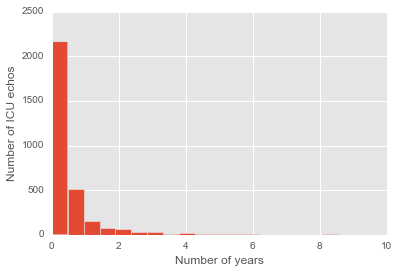

In [40]:
(efv['op_to_icu']/np.timedelta64('1', 'Y')).hist(bins = 20)
plt.xlabel('Number of years')
plt.ylabel('Number of ICU echos')

After

In [42]:
print('Number of ICU echos: {0}'.format(efv.loc[~efv['icu_to_op'].isnull()].shape[0]))
print('Number of unique subject_ids: {0}'.format(efv.loc[~efv['icu_to_op'].isnull(), 'subject_id'].unique().shape[0]))

Number of ICU echos: 1756
Number of unique subject_ids: 1020


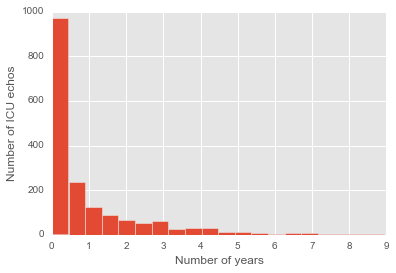

In [43]:
(efv['icu_to_op']/np.timedelta64('1', 'Y')).hist(bins = 20)
plt.xlabel('Number of years')
plt.ylabel('Number of ICU echos')

Before and after

In [50]:
print('Number of ICU echos: {0}'.format(efv.loc[~efv['icu_to_op'].isnull() & 
                                                ~efv['op_to_icu'].isnull()].shape[0]))
print('Number of subject_ids: {0}'.format(efv.loc[~efv['icu_to_op'].isnull() & 
                                                ~efv['op_to_icu'].isnull(), 
                                                'subject_id'].unique().shape[0]))

Number of ICU echos: 482
Number of subject_ids: 254


Of the echos which have echos before and after, how many filters are passed/failed? 

In [63]:
efv.loc[~efv['icu_to_op'].isnull() & ~efv['op_to_icu'].isnull(), 
        ['ps_vaso', 'diag_xc', 'time_filter', 'age_filter']].sum()

ps_vaso        237
diag_xc        423
time_filter    392
age_filter     482
dtype: int64